In [2]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Creating and training model

## Train and Test data

In [14]:
# train
trainDataRaw = pd.read_csv('../../../datasets/fraudTest.csv')
#print(trainDataRaw.shape)
#print(trainDataRaw.head())

In [33]:
#SOBREMUESTREO
fraudes = trainDataRaw[trainDataRaw['is_fraud']==1]
no_fraudes = trainDataRaw[trainDataRaw['is_fraud']==0]

In [34]:
sobremuestreo_fraude = fraudes.sample(n=400000, replace = True, random_state=0)
#sobremuestreo_fraude

In [35]:
sobremuestreo_nofraude = no_fraudes.sample(n=500000, replace = False, random_state=0)
#sobremuestreo_nofraude

In [36]:
#concatenacion

trainDataRaw = pd.concat([sobremuestreo_nofraude, sobremuestreo_fraude], axis=0, ignore_index=True)
#trainDataRaw

In [37]:
trainDataRaw.shape

(900000, 23)

## Visualizing Data

In [38]:
print(trainDataRaw['is_fraud'].value_counts())

is_fraud
0    500000
1    400000
Name: count, dtype: int64


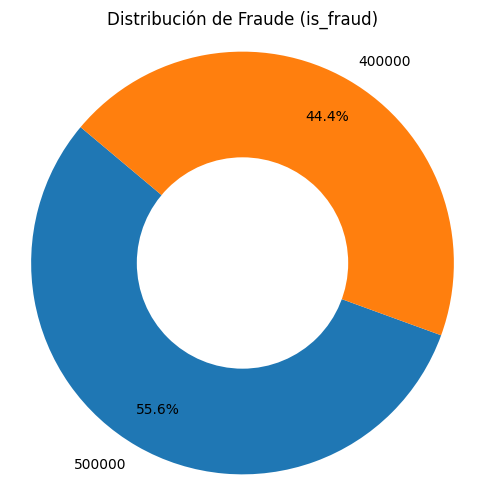

In [39]:
piecito = trainDataRaw['is_fraud'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(piecito, labels=piecito, autopct='%1.1f%%', pctdistance=0.8 , startangle=140)

cir = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(cir)

plt.title('Distribución de Fraude (is_fraud)')
plt.axis('equal')

plt.show()


## Data cleaning (trainData)

In [45]:
columns_out = ['Unnamed: 0', 'cc_num', 'merchant', 'state', 'first', 'last', 'gender', 'street', 'city', 'zip', 'city', 'job', 'dob', 'trans_num', 'unix_time']

In [46]:
trainData = trainDataRaw.drop(columns=columns_out)

In [47]:
# 'Chocolateo'
trainData = trainData.sample(frac=1).reset_index(drop=True)

## Data Cleaning

In [48]:
# Category encoding
Xtrain = pd.get_dummies(trainData, columns=['category'], prefix='cat')
Xtrain = Xtrain.drop(columns=['is_fraud'])
# Date encoding
Xtrain['hour'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.hour
Xtrain['day'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.day_of_week
Xtrain['month'] = pd.to_datetime(trainData['trans_date_trans_time']).dt.month
Xtrain = Xtrain.drop(columns=['trans_date_trans_time'])
print(Xtrain.shape)

(900000, 23)


In [49]:
Xtrain.head()

,amt,lat,long,city_pop,merch_lat,merch_long,cat_entertainment,cat_food_dining,cat_gas_transport,cat_grocery_net,...,cat_kids_pets,cat_misc_net,cat_misc_pos,cat_personal_care,cat_shopping_net,cat_shopping_pos,cat_travel,hour,day,month
0,1128.66,36.7410,-108.3510,6910,37.469160,-108.865800,False,False,False,False,...,False,False,False,False,True,False,False,23,0,9
1,10.32,45.7364,-94.1658,6263,45.707033,-93.280211,False,False,False,False,...,False,False,False,False,False,False,True,22,4,7
2,881.12,55.4732,-133.1171,1920,56.034742,-132.408328,False,False,False,False,...,False,False,False,False,True,False,False,23,3,12
3,333.73,39.3900,-88.9597,1532,39.249456,-89.353877,False,False,False,False,...,False,False,False,False,False,False,False,1,4,11
4,60.46,36.7779,-81.7676,5657,36.638717,-81.949226,False,False,False,False,...,False,False,False,False,False,False,False,12,3,7


In [50]:
ytrain = trainData['is_fraud']
#print(ytrain.head())
#print(ytrain.shape)
ytrain

0         1
1         1
2         1
3         1
4         0
         ..
899995    1
899996    0
899997    1
899998    0
899999    0
Name: is_fraud, Length: 900000, dtype: int64

In [51]:
Xtrain.shape

(900000, 23)

## Training the model

In [52]:
X, Xtest, y, ytest = train_test_split(Xtrain, ytrain, test_size=0.20, random_state=42, stratify=ytrain)

scaler = StandardScaler()
X = scaler.fit_transform(X)
Xtest = scaler.transform(Xtest)

In [53]:
# Modelo feed-forward
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu', input_dim=X.shape[1]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
# X.shape[1] = 23

In [54]:
# Learning rate for RMSprop
lr = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

In [55]:
# Compile
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9153 (35.75 KB)
Trainable params: 9153 (35.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
# Train
model.fit(X, y, epochs=10, batch_size=16, validation_data=(Xtest, ytest))
model.save('detectorV6.h5')

Epoch 1/10
45000/45000 [==============================] - 63s 1ms/step - loss: 0.1806 - accuracy: 0.9273 - val_loss: 0.1004 - val_accuracy: 0.9621
Epoch 2/10
45000/45000 [==============================] - 62s 1ms/step - loss: 0.0988 - accuracy: 0.9623 - val_loss: 0.1027 - val_accuracy: 0.9601
Epoch 3/10
45000/45000 [==============================] - 62s 1ms/step - loss: 0.0952 - accuracy: 0.9639 - val_loss: 0.0929 - val_accuracy: 0.9646
Epoch 4/10
45000/45000 [==============================] - 62s 1ms/step - loss: 0.0927 - accuracy: 0.9652 - val_loss: 0.0857 - val_accuracy: 0.9671
Epoch 5/10
45000/45000 [==============================] - 62s 1ms/step - loss: 0.0892 - accuracy: 0.9660 - val_loss: 0.0893 - val_accuracy: 0.9678
Epoch 6/10
45000/45000 [==============================] - 62s 1ms/step - loss: 0.0881 - accuracy: 0.9669 - val_loss: 0.0828 - val_accuracy: 0.9691
Epoch 7/10
45000/45000 [==============================] - 62s 1ms/step - loss: 0.0875 - accuracy: 0.9678 - val_loss: 0

c:\Users\U S U A R I O\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
# Evaluate the model
predict = model.predict(Xtest)

5625/5625 [==============================] - 5s 938us/step


In [58]:
predict = (predict > 0.5) # if prob > 0.5 is fraud and vice versa

In [59]:
# Confusion matrix
confusion = confusion_matrix(ytest, predict)
print("Confusion Matrix:")
print(confusion)
# Correct 0 - Incorrect 1
# Incorrect 0 - Correct 1
#TN FP
#FN TP

Confusion Matrix:
[[96607  3393]
 [ 1476 78524]]


In [60]:
# Classification report
report = classification_report(ytest, predict)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    100000
           1       0.96      0.98      0.97     80000

    accuracy                           0.97    180000
   macro avg       0.97      0.97      0.97    180000
weighted avg       0.97      0.97      0.97    180000

